In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [13]:
num_epochs = 10
batch_sizes = [32, 128, 512, 1024, 2048]
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Transform for MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

In [14]:
"""
    A simple feedforward neural network for image classification tasks, particularly designed 
    for datasets like MNIST with 28x28 pixel grayscale images. The model consists of four 
    fully connected layers with ReLU activation functions and dropout for regularization.

    Architecture:
    - Input Layer: Takes input images reshaped into a vector of 784 features (28*28).
    - Hidden Layer 1: Fully connected layer transforming 784 features to 256 features, followed by ReLU activation and dropout.
    - Hidden Layer 2: Fully connected layer transforming 256 features to 128 features, followed by ReLU activation and dropout.
    - Hidden Layer 3: Fully connected layer transforming 128 features to 64 features, followed by ReLU activation.
    - Output Layer: Maps the 64 features to 10 output classes, suitable for classification tasks with 10 categories.

    Dropout is applied after the first two hidden layers with a 50% dropout rate to prevent 
    overfitting by randomly setting half of the neurons to zero during training.
    
    """

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)      # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                 # Apply dropout after the first layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)                 # Apply dropout after the second layer
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [15]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

In [16]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
def train_and_evaluate(batch_size, learning_rate):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        test_loss, test_acc = test(model, test_loader, criterion)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Batch Size: {batch_size}, LR: {learning_rate}')
        print(f'Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.6f}, Test Acc: {test_acc:.2f}%')
    
    return model, train_loss, test_loss, train_acc, test_acc

In [18]:
def compute_sensitivity(model, test_loader):
    sensitivities = []
    model.eval()  # Set model to evaluation mode

    for images, _ in test_loader:
        images = images.to(device)
        images.requires_grad = True  # Enable gradient calculation for inputs
        
        outputs = model(images)
        # Calculate the Frobenius norm of the Jacobian
        gradients = torch.autograd.grad(outputs=outputs, inputs=images,
                                        grad_outputs=torch.ones(outputs.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        # Calculate Frobenius norm of gradients (Jacobian matrix)
        frobenius_norm = torch.norm(gradients, p='fro').item()
        sensitivities.append(frobenius_norm)
        
        # Clear gradients for next iteration
        images.grad = None
    
    return np.mean(sensitivities)

In [19]:
results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'sensitivity': []}

for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    model, train_loss, test_loss, train_acc, test_acc = train_and_evaluate(batch_size, learning_rate)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    sensitivity = compute_sensitivity(model, test_loader)
    
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    results['sensitivity'].append(sensitivity)


Epoch [1/10] - Batch Size: 32, LR: 0.1
Train Loss: 3.146128, Train Acc: 10.36%
Test Loss: 2.314799, Test Acc: 9.74%
Epoch [2/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.314045, Train Acc: 10.31%
Test Loss: 2.306589, Test Acc: 10.09%
Epoch [3/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.314565, Train Acc: 10.20%
Test Loss: 2.313697, Test Acc: 10.09%
Epoch [4/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.313370, Train Acc: 10.56%
Test Loss: 2.314869, Test Acc: 10.10%
Epoch [5/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.314090, Train Acc: 10.24%
Test Loss: 2.316400, Test Acc: 10.32%
Epoch [6/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.314323, Train Acc: 10.29%
Test Loss: 2.317767, Test Acc: 9.80%
Epoch [7/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.313613, Train Acc: 10.46%
Test Loss: 2.315661, Test Acc: 10.28%
Epoch [8/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.314102, Train Acc: 10.35%
Test Loss: 2.312488, Test Acc: 9.58%
Epoch [9/10] - Batch Size: 32, LR: 0.1
Train Loss: 2.313606, Train 

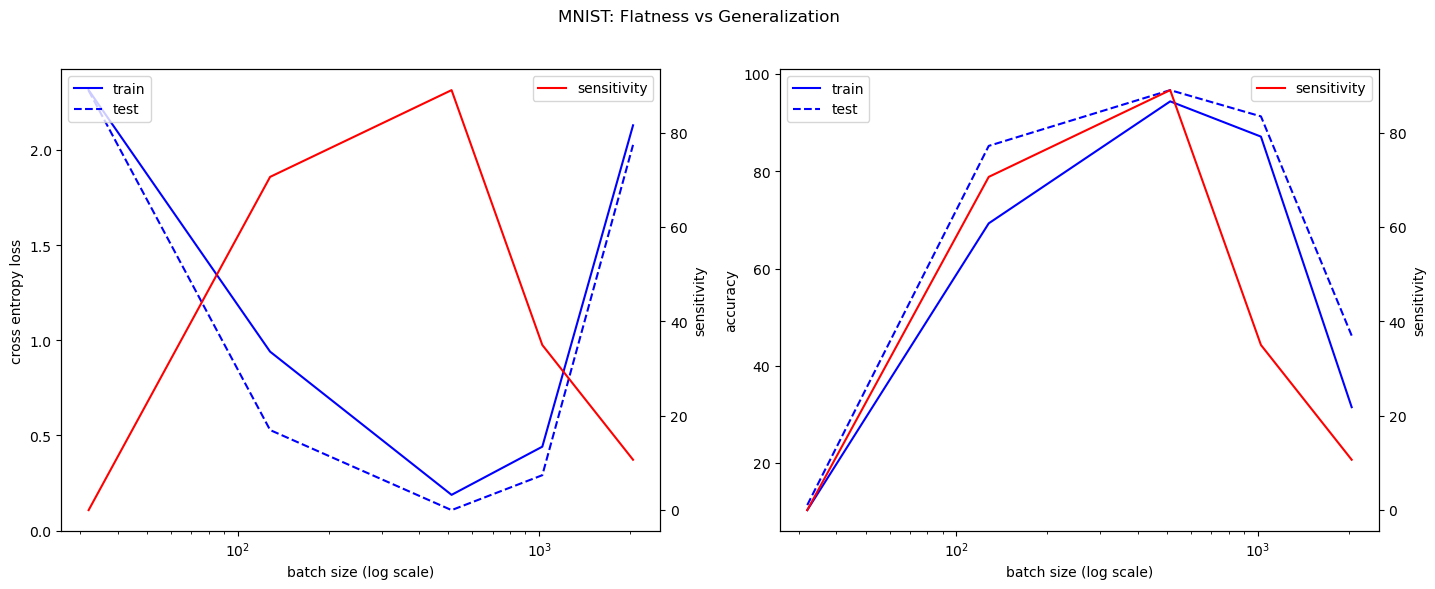

In [20]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(17, 6))

# First plot: Loss vs Sensitivity
ax1 = axs[0]
ax2 = ax1.twinx()
ax1.plot(batch_sizes, results['train_loss'], label='train', color='blue')
ax1.plot(batch_sizes, results['test_loss'], label='test', linestyle='--', color='blue')
ax2.plot(batch_sizes, results['sensitivity'], label='sensitivity', color='red')
ax1.set_xscale('log')
ax1.set_xlabel('batch size (log scale)')
ax1.set_ylabel('cross entropy loss')
ax2.set_ylabel('sensitivity')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Second plot: Accuracy vs Sensitivity
ax1 = axs[1]
ax2 = ax1.twinx()
ax1.plot(batch_sizes, results['train_acc'], label='train', color='blue')
ax1.plot(batch_sizes, results['test_acc'], label='test', linestyle='--', color='blue')
ax2.plot(batch_sizes, results['sensitivity'], label='sensitivity', color='red')
ax1.set_xscale('log')
ax1.set_xlabel('batch size (log scale)')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('sensitivity')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.suptitle('MNIST: Flatness vs Generalization')
plt.show()